In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [24, 16]

In [2]:
def f(x, y):
     return x ** 2 + y ** 2

In [3]:
def painter_decorator3d(func):
    def draw(*args, **kwargs):
        points = func(*args, **kwargs)
        xx = points[:, 0]
        yy = points[:, 1]
        zz = f(xx, yy)
        
        maxx = max(max(xx), max(yy))
        x = np.linspace(-maxx, maxx, 200)
        y = np.linspace(-maxx, maxx, 200)
        x, y = np.meshgrid(x, y)
        z = f(x, y)

        figure = plt.figure()
        figure.patch.set_facecolor('white')
        std_view = figure.add_subplot(1, 2, 1, projection='3d')
        std_view.contour3D(x, y, z, 50, alpha=.3, cmap='binary')
        std_view.scatter(xx, yy, zz, c='w', s=30)
        std_view.axis('off')
        
        upper_view = figure.add_subplot(1, 2, 2, projection='3d')
        upper_view.contour3D(x, y, z, 50, alpha=.3, cmap='binary')
        upper_view.scatter(xx, yy, zz, c='w', s=30)
        upper_view.view_init(90, 0)
        upper_view.axis('off')
    return draw

In [4]:
@painter_decorator3d
def gradient_discent(gradient, start_point, learning_rate, tolerance=1e-3, n_iter=100):
    points = np.array([start_point])
    for _ in range(n_iter):
        step = -learning_rate * gradient(points[-1])
        if np.all(np.abs(step)) < tolerance:
            break
        points = np.concatenate((points, np.array([points[-1] + step])))
    return points

### Optimal learning_rate

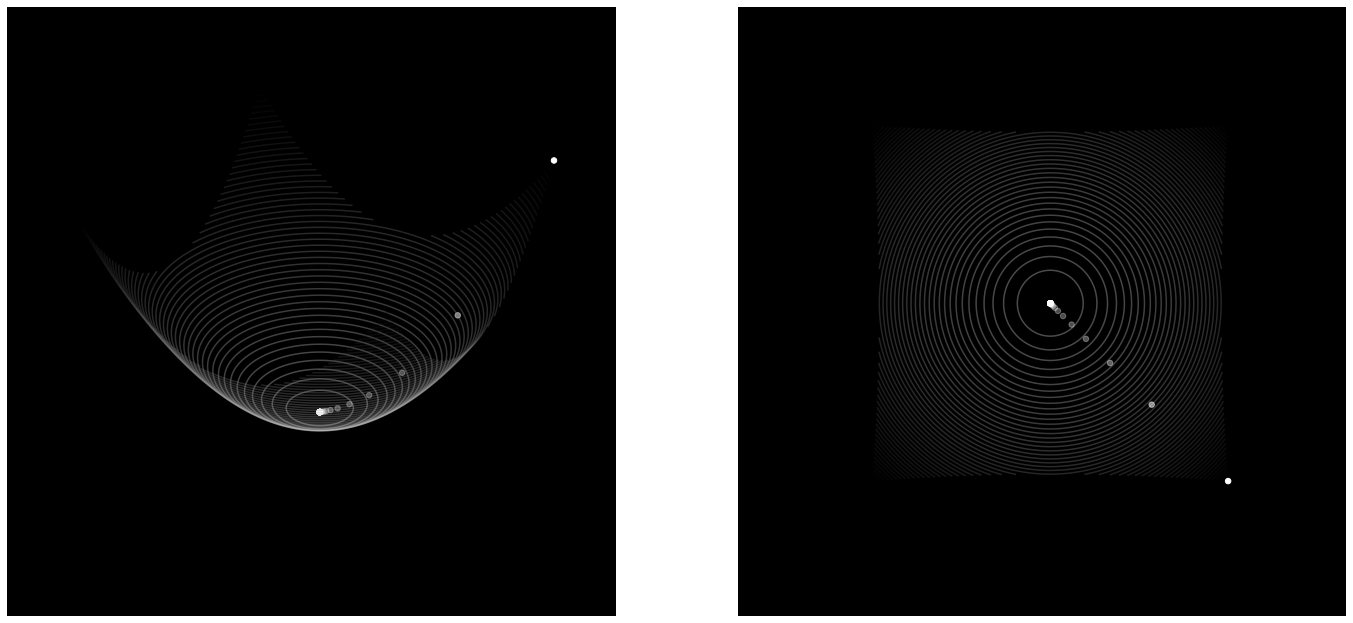

In [5]:
gradient_discent(lambda v: np.array([2 * v[0], 2 * v[1]]), np.array([1, 1]), 0.2)

### Large learning_rate

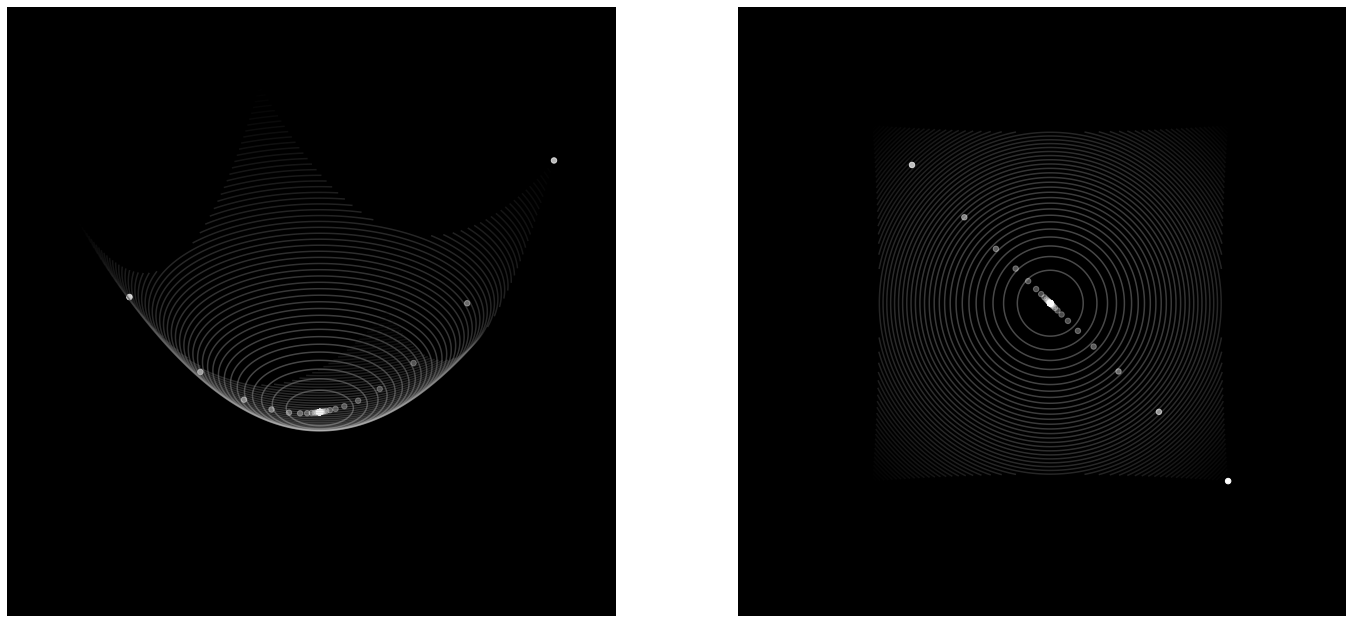

In [6]:
gradient_discent(lambda v: np.array([2 * v[0], 2 * v[1]]), np.array([1, 1]), 0.9)

### Small learning_rate

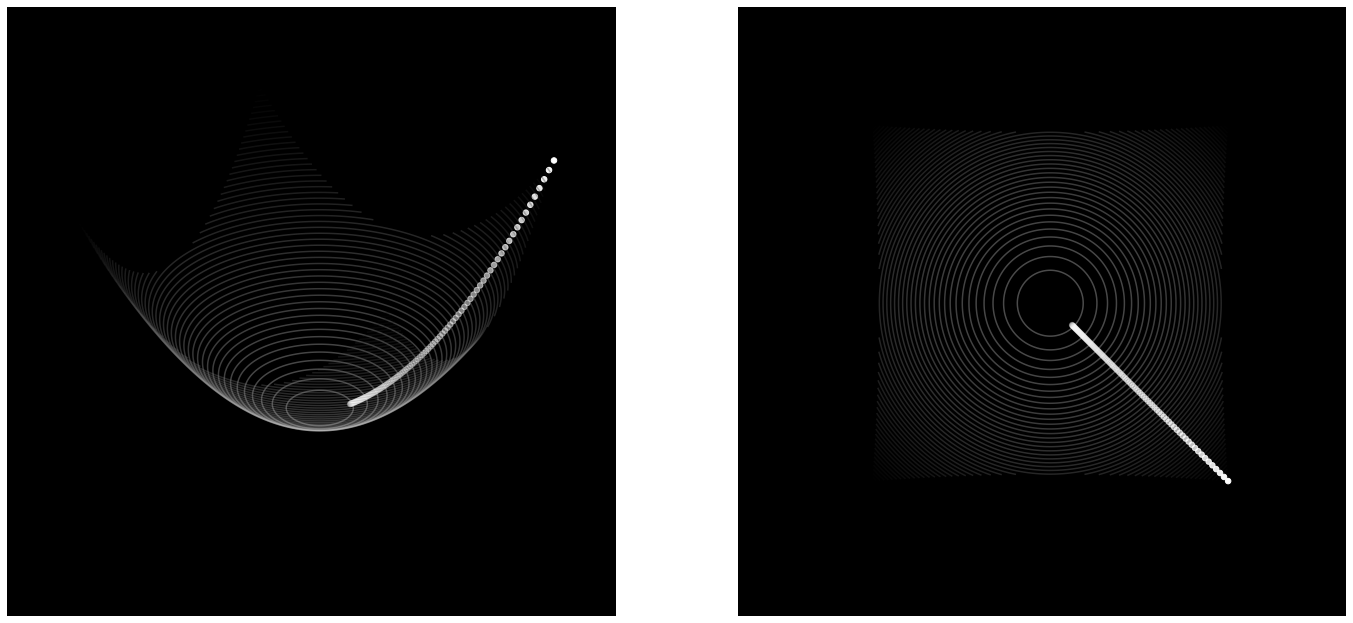

In [7]:
gradient_discent(lambda v: np.array([2 * v[0], 2 * v[1]]), np.array([1, 1]), 0.01)